# Fashion Journalism and Chatbots: A Quantitative Analysis of Potential Benefits and Risks Associated with the Adoption of AI-based Digital Tools for Sustainable Fashion Content Creation

*Supporting Notebook*

This research aims to contribute to the understanding of the impact of Artificial Intelligence on Fashion Journalism, particularly on Sustainable Fashion Journalism, evaluating both the risks that careless use of these technologies might imply and what their potential benefits could be in enabling and augmenting the work of conscious professionals.

This paper leverages quantitative textual analysis, based on inductive techniques (Hovy, 2022) where texts are taken as input and structures are identified to explain their content. The computational methods approach involves the creation of a Spanish-language dataset composed of three groups of sustainable fashion news articles from diverse authors: Latin American journalists, Spanish journalists, and AI-based chatbots.

### Research Questions

1. What are the differences and similarities between journalistic texts written by human journalists and chatbots?
1. What are the narratives that chatbots pick up and perpetuate around sustainable fashion in Latin America and Spain?
1. How might chatbots influence the way fashion journalists write about sustainable fashion?

### Explanation of the variables of the dataset 

The dataset has 8 columns, and the following information was obtained from a total of 1150 fashion journalist articles, of which 624 were written by Latin American journalists, 425 by Spanish journalists and 86 by three different chatbots, , during a period of time from 2011 to 2023. The creation of the articles by ChatGPT-3.5, Perplexity and Jasper were created during the March and April 2023.

| Information | Description |
| --- | --- |
| Source | Name of the magazine or chatbot | 
| Source_type | Human or chatbot |
| Date | Date of publication of the article |
| Author | Name of person, media or chatbot signing the article |
| Headline | Title of the article |
| Lead | Article lead |
| Body | Content of the article |
| Keywords | The list of hashtags/tag in a text |
| Country | Origin of the media. NOTE: This field was left empty for chatbots  |

In [1]:
%pip install colorcet gensim nltk spacy spacy_spanish_lemmatizer wordcloud
!python -m spacy download es_core_news_md
!python -m spacy_spanish_lemmatizer download wiki

Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 42.3/42.3 MB 3.9 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
Decompressing dump file: C:\Users\pilyu\anaconda3\Lib\site-packages\spacy_spanish_lemmatizer\tmp\eswiktionary-latest-pages-articles.xml.bz2
Parsing downloaded file...
Generating lemmatization...
Exporting lemmatizer files...
Cleaning temporary files...


In [2]:
import urllib.request
from collections import Counter
from glob import glob

import colorcet as cc
import gensim
import nltk
import pandas as pd
import seaborn as sns
import spacy
import spacy_spanish_lemmatizer
from gensim.models import KeyedVectors, Word2Vec
from matplotlib import pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud

nltk.download("stopwords")

url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-es/master/stopwords-es.txt"
with urllib.request.urlopen(url) as response:
    stopwords = response.read().decode("utf-8")
stopwords = stopwords.split("\n")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pilyu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Create the dataframe structure
df = pd.DataFrame(
    columns=[
        "source",
        "source_type",
        "date",
        "author",
        "headline",
        "lead",
        "body",
        "keywords",
        "country",
    ]
)

# Data sources
input_data = {
    "jasper.csv": "chatbot",
    "chatgpt.csv": "chatbot",
    "perplexity.csv": "chatbot",
    "cosas_pe.csv": "human",
    "harpersbazaar_mx.csv": "human",
    "instyle_es.csv": "human",
    "lofficiel_ar.csv": "human",
    "oceandrive_ve.csv": "human",
    "paula_cl.csv": "human",
    "somosohlala_ar.csv": "human",
    "telva_es.csv": "human",
    "vistelacalle_cl.csv": "human",
    "vogue_es.csv": "human",
    "vogue_mx.csv": "human",
}

# Read all the data files and set the corresponding source type, chatbot or human
for filename, source_type in input_data.items():
    data = pd.read_csv(
        f"../data/{filename}", header=0, delimiter=",", encoding="utf-8", dtype=str
    )
    data["source_type"] = source_type
    df = pd.concat([df, data], ignore_index=True)

# Format the dates properly
df["date"] = pd.to_datetime(df["date"], format="ISO8601", utc=True)

# Apply consistent casing to author names
df["author"] = df["author"].str.title()

# Put all keywords in lowercase
df["keywords"] = df["keywords"].str.lower()

# Extract a sample to verify that the data looks good
df.sample(10, random_state=42)

,source,source_type,date,author,headline,lead,body,keywords,country
174,Revista COSAS,human,2022-05-13 21:09:16+00:00,Arianna Gonzales,"El look de Sassa de Osma, perfecto para adopta...",Sassa de Osma vuelve a sorprender con sus esti...,Sassa de Osma vuelve a sorprender con sus esti...,"looks de sassa de osma,sassa de osma",Peru
752,Viste La Calle,human,2018-10-09 13:00:59+00:00,Kevin Cortés,"Renace, una pasarela dedicada 100% a la moda s...","Fotos: Maglio Cicardini (@ballentinno), Isidor...","Fotos: Maglio Cicardini (@ballentinno), Isidor...",moda,Chile
467,Ocean Drive,human,2020-07-17 01:27:59+00:00,Mary Villarroel Sneshko.,“Heart for hope”: Carolina Herrera se une con ...,La reconocida casa de moda ha buscado la maner...,La reconocida casa de moda ha buscado la maner...,"covid-19,moda",Venezuela
240,Harper's Bazaar,human,2022-05-13 00:00:00+00:00,Lorenza García,5 marcas ecológicas de ropa interior que debes...,Si estás haciendo todo lo posible por comprar ...,"Hay muchas marcas que ofrecen estilo, comodida...","moda sostenible,lenceria,marcas de lenceria,ma...",Mexico
667,Telva,human,2022-01-18 10:45:18+00:00,Elisa Álvarez Espejo,Las 5 veces que la Reina Letizia ha asaltado e...,Hace 4 años que la reina Letizia hizo incursió...,No sabemos muy bien cómo se abrió la veda en e...,"reina letizia,looks,moda,moda sostenible",Spain
218,Revista COSAS,human,2018-05-08 21:41:09+00:00,Isabel Miró Quesada,"Met Gala 2018: los mejores y los peores looks,...",Conversamos con el diseñador peruano Noe Berna...,Moda y religión se fusionaron en la esperada M...,met gala,Peru
867,Vogue Spain,human,2022-11-30 08:34:45.311000+00:00,Emily Chan,¿Cuántas prendas deberíamos tener exactamente?,Un informe del Instituto Hot Or Cool de Berlín...,"""Comprar menos y comprar mejor"" se ha converti...","sostenibilidad,vogue 365",Spain
420,Ocean Drive,human,2023-01-10 15:45:00+00:00,Mary Villarroel Sneshko.,¿Quién es Amanda Dudamel? 5 datos de nuestra M...,"Elocuente, extrovertida y con una soltura impr...","Elocuente, extrovertida y con una soltura impr...",NaN,Venezuela
351,InStyle,human,2020-06-05 15:24:42+00:00,María Elvira,Marcas de belleza responsables con el medio am...,"Por el Día de la Tierra, repasamos siete marca...",Belleza cosmética El mundo se ha parado en los...,"cosmética,looks de moda,trucos de belleza,prod...",Spain
328,InStyle,human,2020-09-13 14:00:00+00:00,María Elvira,Cómo cuidar tu melena con los mejores ingredie...,Belleza productos de belleza Si el pelo de tod...,Porque el valor de tu melena es incalculable. ...,productos de belleza,Spain


In [4]:
# Replace missing headlines, leads, or article bodies with an empty string
df[["headline", "lead", "body"]] = df[["headline", "lead", "body"]].fillna("")
df

,source,source_type,date,author,headline,lead,body,keywords,country
0,Jasper,chatbot,2023-04-05 13:34:25+00:00,Jasper,La industria de la moda es uno de los sectores...,Implica todos los aspectos relacionados con el...,La industria de la moda está experimentando un...,"moda,industria de la moda",NaN
1,Jasper,chatbot,2023-04-05 13:34:25+00:00,Jasper,Industria de la moda y moda sostenible,La palabra moda en los últimos años ha recibid...,Estamos viendo cada vez más marcas y diseñador...,"moda,industria de la moda,moda latinoamericana...",NaN
2,Jasper,chatbot,2023-04-05 13:34:25+00:00,Jasper,¿Cómo la industria de la moda latinoamericana ...,La industria de la moda latinoamericana está g...,La industria de la moda latinoamericana está g...,"moda,industria de la moda,moda latinoamericana...",NaN
3,Jasper,chatbot,2023-04-05 13:34:25+00:00,Jasper,"Industria de la moda, moda sostenible y moda s...",En un mundo donde la sostenibilidad ambiental ...,Desde prendas hechas con materiales reciclados...,"industria de la moda,moda sostenible,moda sust...",NaN
4,Jasper,chatbot,2023-04-05 13:34:25+00:00,Jasper,La industria de la moda se une para el Día Mun...,"Cada año, el 22 de marzo se celebra el Día Mun...","Cada año, el 22 de marzo se celebra el Día Mun...","moda,industria de la moda,día del agua,medioam...",NaN
...,...,...,...,...,...,...,...,...,...
1145,Vogue Mexico,human,2023-04-28 17:08:36+00:00,Luz García,Blake Lively confirma la tendencia de los vest...,Serena van der Woodsen estaría orgullosa de la...,A casi un año del performance que Blake Lively...,blake lively,Mexico
1146,Vogue Mexico,human,2023-04-28 16:59:40+00:00,Katharina Fuchs,Dakota Johnson eleva un crop top básico con pa...,Los crop tops lisos no son precisamente famoso...,Dakota Johnson lo demuestra con su look más re...,dakota johnson,Mexico
1147,Vogue Mexico,human,2023-04-28 17:36:44+00:00,Alice Cary,Cómo llevar vestido boho transparente y lucir ...,Los vestidos boho son versátiles e ideales par...,Los vestidos boho definieron el estilo de la a...,vestidos,Mexico
1148,Vogue Mexico,human,2023-04-28 18:01:10+00:00,Renata Joffre,Anitta lleva pantalones baggy y sandalias de t...,La cantante brasileña incendia las cámaras al ...,La Quinta Avenida se llenó de celebridades de ...,"anitta,sandalias,pantalones",Mexico


In [5]:
# Review the dataset structure, non-null values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   source       1150 non-null   object             
 1   source_type  1150 non-null   object             
 2   date         1150 non-null   datetime64[ns, UTC]
 3   author       1150 non-null   object             
 4   headline     1150 non-null   object             
 5   lead         1150 non-null   object             
 6   body         1150 non-null   object             
 7   keywords     1074 non-null   object             
 8   country      1064 non-null   object             
dtypes: datetime64[ns, UTC](1), object(8)
memory usage: 81.0+ KB


In [6]:
# Count the null values by column. Some missing values are expected because not all articles/websites have tags, and chatbots have no country assigned.
print("Nul values in the dataset by column:")
df.isna().sum()

Nul values in the dataset by column:


source          0
source_type     0
date            0
author          0
headline        0
lead            0
body            0
keywords       76
country        86
dtype: int64

In [7]:
# Show dataset statistics
df.describe()

,source,source_type,date,author,headline,lead,body,keywords,country
count,1150,1150,1150,1150,1150,1150,1150,1074,1064
unique,14,2,NaN,221,1140,1143,1149,840,6
top,Vogue Spain,human,NaN,Isabel Miró Quesada,Conoce las marcas de ropa sostenible en España...,La moda sostenible es una tendencia mundial qu...,Estamos aquí para examinar todo lo relacionado...,moda,Spain
freq,243,1064,NaN,76,3,3,2,114,415
mean,NaN,NaN,2020-09-08 13:11:18.960533760+00:00,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,2007-09-30 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2019-11-29 05:15:09.249999872+00:00,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,2020-12-03 08:59:38+00:00,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2022-05-12 17:07:29.750000128+00:00,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,2023-04-28 18:01:10+00:00,NaN,NaN,NaN,NaN,NaN,NaN


### Exploring the data

In [8]:
# Define some useful sub-datasets, with article breakdown by source type
subdf_human = df[df["source_type"] == "human"]
subdf_chatbot = df[df["source_type"] == "chatbot"]

In [9]:
# Count the number of articles (global and by source type)
print(f"Total number of articles in the dataset: {len(df)}")

Total number of articles in the dataset: 1150


Human-written articles: 1064
Chatbot-written articles: 86


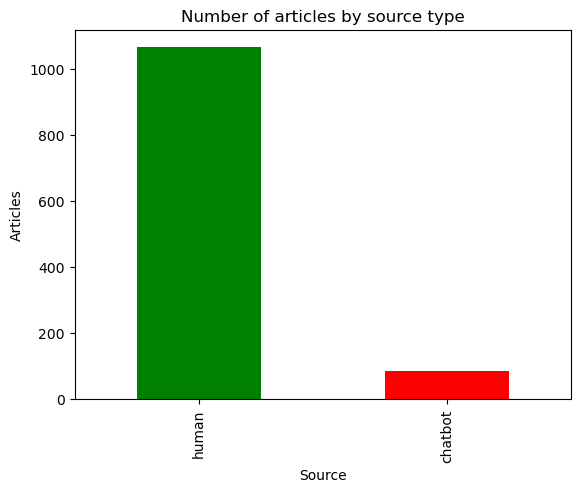

In [10]:
# Count and visualize the number of articles by source type
print(f"Human-written articles: {len(subdf_human)}")
print(f"Chatbot-written articles: {len(subdf_chatbot)}")

source_counts = df["source_type"].value_counts()
barplot = source_counts.plot.bar(color=["g", "r"])
plt.title("Number of articles by source type")
plt.xlabel("Source")
plt.ylabel("Articles")
plt.show()

In [11]:
# Count articles by source
print("Article breakdown by source:")
df["source"].value_counts()

Article breakdown by source:


source
Vogue Spain        243
Viste La Calle     167
Revista COSAS      145
Ocean Drive         96
Telva               94
InStyle             78
Paula               70
Harper's Bazaar     58
Vogue Mexico        48
L'Officiel          40
Perplexity          36
ChatGPT-3.5         34
Ohlalá              25
Jasper              16
Name: count, dtype: int64

In [12]:
# Break down articles by country (does not show chatbots)
print("Article breakdown by country:")
df["country"].value_counts()

Article breakdown by country:


country
Spain        415
Chile        237
Peru         145
Mexico       106
Venezuela     96
Argentina     65
Name: count, dtype: int64

In [13]:
# Define a custom color palette with enough colors to differentiate all sources
palette = sns.color_palette(cc.glasbey, n_colors=df["source"].nunique())
sns.set_palette(palette)

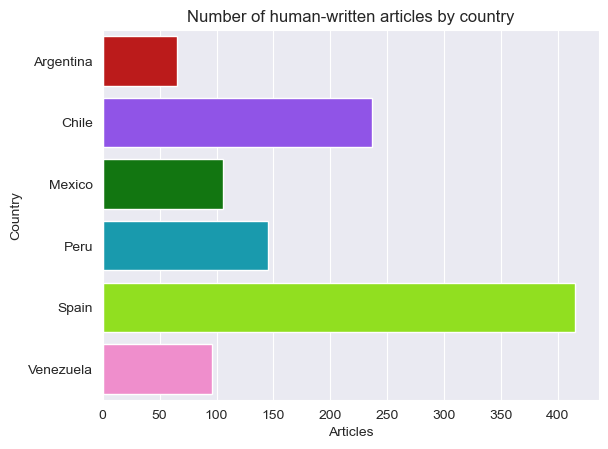

In [14]:
# Group by country and source type and count the number of articles
article_count = df.groupby(["country"]).size().reset_index(name="article_count")

# Create a horizontal bar plot
sns.set_style("darkgrid")
ax = sns.barplot(x="article_count", y="country", data=article_count)

# Add labels and title
ax.set_xlabel("Articles")
ax.set_ylabel("Country")
ax.set_title("Number of human-written articles by country")

# Show the plot
plt.show()

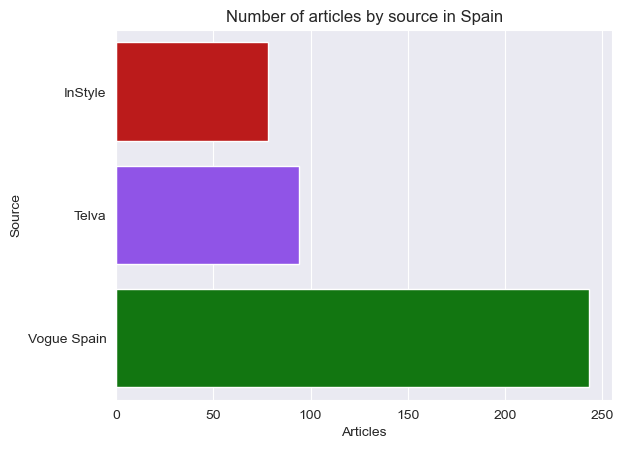

In [15]:
# Group by Spanish magazines and count the number of articles
spain_df = df[df["country"] == "Spain"]
spain_magazine_article_count = (
    spain_df.groupby("source").size().reset_index(name="spain_magazine_article_count")
)

# Create a horizontal bar plot
sns.set_style("darkgrid")
ax = sns.barplot(
    x="spain_magazine_article_count", y="source", data=spain_magazine_article_count
)

# Add labels and title
ax.set_xlabel("Articles")
ax.set_ylabel("Source")
ax.set_title("Number of articles by source in Spain")

# Show the plot
plt.show()

In [16]:
# Break down articles by author
author_counts = subdf_human["author"].value_counts()
print("Top 10 human authors:")
print(author_counts.head(10))

Top 10 human authors:
author
Isabel Miró Quesada        76
Emily Chan                 74
Vistelacalle               68
Luis Fernando Jimenez      47
Harper’S Bazaar            44
Arianna Gonzales           40
Andrea Martínez Maugard    29
Laura Cadenas              23
Elisa Álvarez Espejo       22
Lidia A. Costa             21
Name: count, dtype: int64


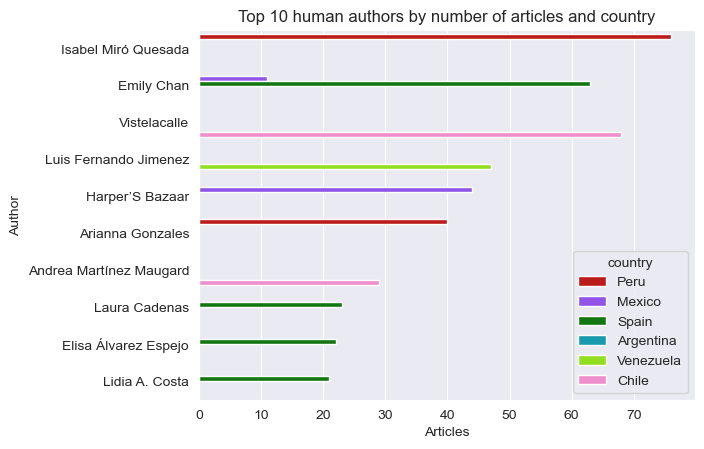

In [17]:
# Visualize articles by author and country
sns.set_style("darkgrid")
ax = sns.countplot(
    y="author",
    hue="country",
    data=subdf_human,
    order=subdf_human["author"].value_counts().iloc[:10].index,
)
ax.set_xlabel("Articles")
ax.set_ylabel("Author")
ax.set_title("Top 10 human authors by number of articles and country")
plt.show()

In [18]:
# Count articles by publication year
year_of_publication = pd.DataFrame(
    {"year": subdf_human["date"].dt.year, "source": subdf_human["source"]}
)
article_counts = year_of_publication["year"].value_counts().reset_index()
article_counts.columns = ["year", "count"]
sorted_article_counts = article_counts.sort_values("count", ascending=False)
print("Articles by year of publication, sorted by quantity:")
print(sorted_article_counts)

Articles by year of publication, sorted by quantity:
    year  count
0   2020    289
1   2021    202
2   2022    191
3   2019    100
4   2023     85
5   2018     72
6   2016     40
7   2017     35
8   2015     25
9   2013      7
10  2014      7
11  2012      6
12  2011      4
13  2007      1


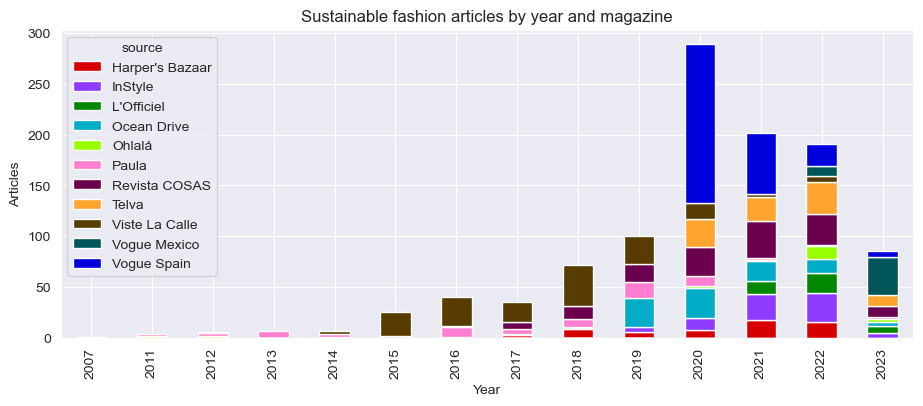

In [19]:
# Create a pivot table to count articles by source so that they can be plotted
pivot_table = year_of_publication.pivot_table(index='year', columns='source', aggfunc='size')

# Create the bar plot
fig, ax = plt.subplots(figsize=(11, 4))
pivot_table.plot(kind='bar', stacked=True, ax=ax)
plt.xlabel('Year')
plt.ylabel('Articles')
plt.title('Sustainable fashion articles by year and magazine')

# Show the graph
plt.show()

## Dataset Preprocessing

### Lexical Variety Analysis

To determine the lexical variety of chatbot- and human-generated articles, a Count Vectorizer will be used. This Count Vectorizer has to count lemmas instead of words, so it will need to be adapted to use a custom tokenizer.

Let's start by creating a Spacy NLP (Natural Language Processor) with the Spanish News Md corpus, and replace the English lemmatizer with a Spanish one to fit the language of the dataset.

In [20]:
# Load Spacy's Spanish News corpus Md, disabling less critical features to improve processing speed
nlp_lemmas = spacy.load("es_core_news_md", disable=["ner", "parser"])

# Replace Spacy's default lemmatizer with a Spanish one to fit the corpus
nlp_lemmas.replace_pipe("lemmatizer", "spanish_lemmatizer")

In [21]:
# Define a lemma tokenizer to evaluate lexical variety
# Adapted from: https://scikit-learn.org/stable/modules/feature_extraction.html#customizing-the-vectorizer-classes
class LemmaTokenizer:
    def __call__(self, doc):
        return [token.lemma_ for token in nlp_lemmas(doc) if not token.is_punct]


# Create count vectorizers that use the lemma tokenizer
lemma_cv_human = CountVectorizer(tokenizer=LemmaTokenizer())
lemma_cv_chatbot = CountVectorizer(tokenizer=LemmaTokenizer())

In [22]:
# Combine the headline, lead, and body of each article into a list of documents that can be processed by the Count Vectorizer
chatbot_texts_combined = subdf_chatbot["headline"] + " " + subdf_chatbot["lead"] + " " + subdf_chatbot["body"]
human_texts_combined = subdf_human["headline"] + " " + subdf_human["lead"] + " " + subdf_human["body"]

# Since the human-written texts are many more than chatbot-written ones, extract a random sample of the same length
human_texts_combined = human_texts_combined.sample(len(chatbot_texts_combined), random_state=42)

# Fit the lemma-based count vectorizers to the document collections
human_count_lemmas = lemma_cv_human.fit_transform(human_texts_combined)
chatbot_count_lemmas = lemma_cv_chatbot.fit_transform(chatbot_texts_combined)

In [23]:
# Compare human/chatbot lexical variety
# The get_shape() method returns a tuple containing the number of rows and columns of the count vectorizers, each column identifies a lemma
print(f"Number of different lemmas employed by human authors: {human_count_lemmas.get_shape()[1]}")
print(f"Number of different lemmas employed by conversational chatbots: {chatbot_count_lemmas.get_shape()[1]}")

Number of different lemmas employed by human authors: 6936
Number of different lemmas employed by conversational chatbots: 2713


#### Analysis of headlines

Headlines, leads, and bodies have to be lemmatized and cleaned from stop words before they can be analyzed. The following reusable functions will take care of it.

In [24]:
# Create a new Spacy NLP with the Spanish News Md corpus, again disabling less critical features for better speed
nlp = spacy.load("es_core_news_md", disable=["ner", "parser"])

# Define a function that, given a document, returns its lemmas without stopwords
def cleaning(doc):
    txt = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and len(token) > 1
    ]  # Tokenize, take out stopwords, and return the lemmas
    return " ".join(txt)


# Define a function that cleans a series of documents, to be used with headlines, leads and bodies
def process(series):
    docs = [row for row in series]
    txts = [
        cleaning(doc) for doc in nlp.pipe(docs, n_process=-1, batch_size=500)
    ]  # nlp.pipe processes documents in batches
    return txts

In [25]:
# Clean all the headlines
df["clean_headline"] = process(df["headline"])
df.sample(10, random_state=42)

,source,source_type,date,author,headline,lead,body,keywords,country,clean_headline
174,Revista COSAS,human,2022-05-13 21:09:16+00:00,Arianna Gonzales,"El look de Sassa de Osma, perfecto para adopta...",Sassa de Osma vuelve a sorprender con sus esti...,Sassa de Osma vuelve a sorprender con sus esti...,"looks de sassa de osma,sassa de osma",Peru,look sassa osma perfecto adoptar cambio estación
752,Viste La Calle,human,2018-10-09 13:00:59+00:00,Kevin Cortés,"Renace, una pasarela dedicada 100% a la moda s...","Fotos: Maglio Cicardini (@ballentinno), Isidor...","Fotos: Maglio Cicardini (@ballentinno), Isidor...",moda,Chile,renace pasarela dedicado 100% moda sustentable
467,Ocean Drive,human,2020-07-17 01:27:59+00:00,Mary Villarroel Sneshko.,“Heart for hope”: Carolina Herrera se une con ...,La reconocida casa de moda ha buscado la maner...,La reconocida casa de moda ha buscado la maner...,"covid-19,moda",Venezuela,heart for hope carolina herrera unir cruz roja...
240,Harper's Bazaar,human,2022-05-13 00:00:00+00:00,Lorenza García,5 marcas ecológicas de ropa interior que debes...,Si estás haciendo todo lo posible por comprar ...,"Hay muchas marcas que ofrecen estilo, comodida...","moda sostenible,lenceria,marcas de lenceria,ma...",Mexico,marca ecológico ropa interior deber radar
667,Telva,human,2022-01-18 10:45:18+00:00,Elisa Álvarez Espejo,Las 5 veces que la Reina Letizia ha asaltado e...,Hace 4 años que la reina Letizia hizo incursió...,No sabemos muy bien cómo se abrió la veda en e...,"reina letizia,looks,moda,moda sostenible",Spain,reina letizia asaltar armario doña sofía
218,Revista COSAS,human,2018-05-08 21:41:09+00:00,Isabel Miró Quesada,"Met Gala 2018: los mejores y los peores looks,...",Conversamos con el diseñador peruano Noe Berna...,Moda y religión se fusionaron en la esperada M...,met gala,Peru,met gala 2018 mejor peor look noe bernacelli
867,Vogue Spain,human,2022-11-30 08:34:45.311000+00:00,Emily Chan,¿Cuántas prendas deberíamos tener exactamente?,Un informe del Instituto Hot Or Cool de Berlín...,"""Comprar menos y comprar mejor"" se ha converti...","sostenibilidad,vogue 365",Spain,prenda debeer exactamente
420,Ocean Drive,human,2023-01-10 15:45:00+00:00,Mary Villarroel Sneshko.,¿Quién es Amanda Dudamel? 5 datos de nuestra M...,"Elocuente, extrovertida y con una soltura impr...","Elocuente, extrovertida y con una soltura impr...",NaN,Venezuela,amanda dudamel dato miss venezuela 2021
351,InStyle,human,2020-06-05 15:24:42+00:00,María Elvira,Marcas de belleza responsables con el medio am...,"Por el Día de la Tierra, repasamos siete marca...",Belleza cosmética El mundo se ha parado en los...,"cosmética,looks de moda,trucos de belleza,prod...",Spain,marca belleza responsable ambiente deber
328,InStyle,human,2020-09-13 14:00:00+00:00,María Elvira,Cómo cuidar tu melena con los mejores ingredie...,Belleza productos de belleza Si el pelo de tod...,Porque el valor de tu melena es incalculable. ...,productos de belleza,Spain,cuidar melena mejor ingrediente pasar pelo pelazo


##### The 20 most common terms in the headlines

In [26]:
# Extract the 20 most frequent terms in all headlines
all_lemmas = [
    lemma
    for headline in df["clean_headline"].astype(str).str.split()
    for lemma in headline
]
lemma_freq = pd.Series(all_lemmas).value_counts()  # Frequency distribution of the words
print(lemma_freq.head(20))

moda              344
sostenible        187
marca              97
ropa               62
sustentable        61
colección          59
industria          55
fashion            46
firma              42
sostenibilidad     37
vestido            33
comprar            33
prenda             33
tendencia          31
consciente         30
armario            30
año                29
él                 28
mundo              25
semana             25
Name: count, dtype: int64


##### Extracting keywords using TF-IDF

In [27]:
# Unify all the headlines in a single document for each source type to be able to compare human- and chatbot-written headlines
unified_human_headline_tokens = df[df["source_type"] == "human"]["clean_headline"].str.cat(sep=" ")
unified_chatbot_headline_tokens = df[df["source_type"] == "chatbot"]["clean_headline"].str.cat(sep=" ")
headline_docs = [
    unified_human_headline_tokens,
    unified_chatbot_headline_tokens,
]

As we convert the headline corpus into just one document we obtain a series of tuples associated with numbers. The first element of the tuple (0) corresponds to the document number analyzed, the second element corresponds to the number assigned to each word. The second column is the frequency of occurrence of that word in the text of the first element of the tuple.

In [28]:
# Use a CountVectorizer to extract the most frequent word among all headlines
headline_cv = CountVectorizer(stop_words=stopwords)
headline_count_tokens = headline_cv.fit_transform(headline_docs)
headline_matrix = pd.DataFrame(headline_count_tokens.toarray(), columns=headline_cv.get_feature_names_out())
headline_most_frequent_words = headline_matrix.idxmax(axis=1)

print(f"Most frequent word in human-written headlines: '{headline_most_frequent_words[0]}'")
print(f"Most frequent word in chatbot-written headlines: '{headline_most_frequent_words[1]}'")

Most frequent word in human-written headlines: 'moda'
Most frequent word in chatbot-written headlines: 'moda'


In [29]:
# How many words to extract from each source type
top_headline_results = 10

# Create a TF-IDF vectorizer and train it on the headlines
tfidf_vectorizer = TfidfVectorizer(stop_words="english")
headline_tfidf = tfidf_vectorizer.fit_transform(headline_docs)

# Convert the vectorized headlines into a concatenated dataframe, then into a dictionary
headline_tfidf_matrix = pd.DataFrame(
    headline_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out()
)
target_dict_tf_idf = headline_tfidf_matrix.to_dict("index")

# Extract the most frequent words for each source type from the headlines
data_repr_tf_idf = {}
for source_type_id, target_words in target_dict_tf_idf.items():
    list_targets = [(k, v) for k, v in target_words.items()]
    list_targets_sorted = sorted(list_targets, key=lambda x: x[1], reverse=True)
    data_repr_tf_idf[source_type_id] = list_targets_sorted[0:top_headline_results]

print(f"Top {top_headline_results} most frequent words in the TF-IDF analysis of human-generated headlines:")
for word, frequency in data_repr_tf_idf[0]:
    print(f"- {word} (TF-IDF frequency: {frequency}, occurrences: {headline_count_tokens.toarray()[0][headline_cv.vocabulary_.get(word)]})")

print(f"\nTop {top_headline_results} most frequent words in  the TF-IDF analysis of chatbot-generated headlines:")
for word, frequency in data_repr_tf_idf[1]:
    print(f"- {word} (TF-IDF frequency: {frequency}, occurrences: {headline_count_tokens.toarray()[1][headline_cv.vocabulary_.get(word)]})")

Top 10 most frequent words in the TF-IDF analysis of human-generated headlines:
- moda (TF-IDF frequency: 0.6128659330194068, occurrences: 259)
- sostenible (TF-IDF frequency: 0.33837771591418986, occurrences: 143)
- colección (TF-IDF frequency: 0.1962175266548609, occurrences: 59)
- marca (TF-IDF frequency: 0.1940347741605844, occurrences: 82)
- firma (TF-IDF frequency: 0.13968027321193485, occurrences: 42)
- ropa (TF-IDF frequency: 0.13961038628627412, occurrences: 59)
- sustentable (TF-IDF frequency: 0.13251155308527715, occurrences: 56)
- comprar (TF-IDF frequency: 0.10974878609509167, occurrences: 33)
- vestido (TF-IDF frequency: 0.10974878609509167, occurrences: 33)
- fashion (TF-IDF frequency: 0.10411622028128918, occurrences: 44)

Top 10 most frequent words in  the TF-IDF analysis of chatbot-generated headlines:
- moda (TF-IDF frequency: 0.803141168017841, occurrences: 85)
- sostenible (TF-IDF frequency: 0.41574366344452945, occurrences: 44)
- industria (TF-IDF frequency: 0.264

#### CORPUS WEB/DIALECTS
The frequency in the WEB/DIALECTS corpus of the top 10 words of the corpus under analysis.

Top 10 most frequent words in human-generated headlines:
- moda 111.297
- sostenible 44.845
- colección 60.164
- marca 231.560
- firma 96.638
- ropa 122.425
- sustentable 18.197
- comprar 246.641
- vestido 57.761
- fashion 7.982

Top 10 most frequent words in chatbot-generated headlines:
- moda 111.297
- sostenible 44.845
- industria 178.067
- marca 231.560
- españa 467.257
- tendencia 108.399
- chile 233.742
- sostenibilidad 21.574
- sustentable 18.197
- aja N/A

These results allow us to observe that headlines written by the chatbot use more frequent or common words compared to headlines written by journalists, who tend to use less common or less frequent words in their headlines.

### Analysis of leads

In [30]:
# Clean all the leads
df["clean_lead"] = process(df["lead"])
df.sample(10, random_state=42)

,source,source_type,date,author,headline,lead,body,keywords,country,clean_headline,clean_lead
174,Revista COSAS,human,2022-05-13 21:09:16+00:00,Arianna Gonzales,"El look de Sassa de Osma, perfecto para adopta...",Sassa de Osma vuelve a sorprender con sus esti...,Sassa de Osma vuelve a sorprender con sus esti...,"looks de sassa de osma,sassa de osma",Peru,look sassa osma perfecto adoptar cambio estación,sassa osma volver sorprender estilismo royal p...
752,Viste La Calle,human,2018-10-09 13:00:59+00:00,Kevin Cortés,"Renace, una pasarela dedicada 100% a la moda s...","Fotos: Maglio Cicardini (@ballentinno), Isidor...","Fotos: Maglio Cicardini (@ballentinno), Isidor...",moda,Chile,renace pasarela dedicado 100% moda sustentable,fotos maglio cicardini @ballentinno isidora pa...
467,Ocean Drive,human,2020-07-17 01:27:59+00:00,Mary Villarroel Sneshko.,“Heart for hope”: Carolina Herrera se une con ...,La reconocida casa de moda ha buscado la maner...,La reconocida casa de moda ha buscado la maner...,"covid-19,moda",Venezuela,heart for hope carolina herrera unir cruz roja...,reconocido casa moda buscar ayudar sobrellevar...
240,Harper's Bazaar,human,2022-05-13 00:00:00+00:00,Lorenza García,5 marcas ecológicas de ropa interior que debes...,Si estás haciendo todo lo posible por comprar ...,"Hay muchas marcas que ofrecen estilo, comodida...","moda sostenible,lenceria,marcas de lenceria,ma...",Mexico,marca ecológico ropa interior deber radar,estar comprar sostenible checo marca ecológico...
667,Telva,human,2022-01-18 10:45:18+00:00,Elisa Álvarez Espejo,Las 5 veces que la Reina Letizia ha asaltado e...,Hace 4 años que la reina Letizia hizo incursió...,No sabemos muy bien cómo se abrió la veda en e...,"reina letizia,looks,moda,moda sostenible",Spain,reina letizia asaltar armario doña sofía,año reina letizia incursión guardarropa suegra...
218,Revista COSAS,human,2018-05-08 21:41:09+00:00,Isabel Miró Quesada,"Met Gala 2018: los mejores y los peores looks,...",Conversamos con el diseñador peruano Noe Berna...,Moda y religión se fusionaron en la esperada M...,met gala,Peru,met gala 2018 mejor peor look noe bernacelli,conversar diseñador peruano noe bernacelli pun...
867,Vogue Spain,human,2022-11-30 08:34:45.311000+00:00,Emily Chan,¿Cuántas prendas deberíamos tener exactamente?,Un informe del Instituto Hot Or Cool de Berlín...,"""Comprar menos y comprar mejor"" se ha converti...","sostenibilidad,vogue 365",Spain,prenda debeer exactamente,informe instituto hot or cool berlín estimar d...
420,Ocean Drive,human,2023-01-10 15:45:00+00:00,Mary Villarroel Sneshko.,¿Quién es Amanda Dudamel? 5 datos de nuestra M...,"Elocuente, extrovertida y con una soltura impr...","Elocuente, extrovertida y con una soltura impr...",NaN,Venezuela,amanda dudamel dato miss venezuela 2021,elocuente extrovertido soltura impresionante c...
351,InStyle,human,2020-06-05 15:24:42+00:00,María Elvira,Marcas de belleza responsables con el medio am...,"Por el Día de la Tierra, repasamos siete marca...",Belleza cosmética El mundo se ha parado en los...,"cosmética,looks de moda,trucos de belleza,prod...",Spain,marca belleza responsable ambiente deber,tierra repasar marca belleza deber respeto pla...
328,InStyle,human,2020-09-13 14:00:00+00:00,María Elvira,Cómo cuidar tu melena con los mejores ingredie...,Belleza productos de belleza Si el pelo de tod...,Porque el valor de tu melena es incalculable. ...,productos de belleza,Spain,cuidar melena mejor ingrediente pasar pelo pelazo,belleza producto belleza pelo cotizar bolsa se...


##### Most frequent words in leads

In [31]:
# Unify all leads to create the input for the Word Cloud
all_keywords = df["clean_lead"].str.cat(sep=" ")

# Create a dictionary which will contain the words as keys and their frequencies as values
word_freq = {}

for word in all_keywords.split():
    if word not in word_freq:
        word_freq[word] = 0
    word_freq[word] += 1

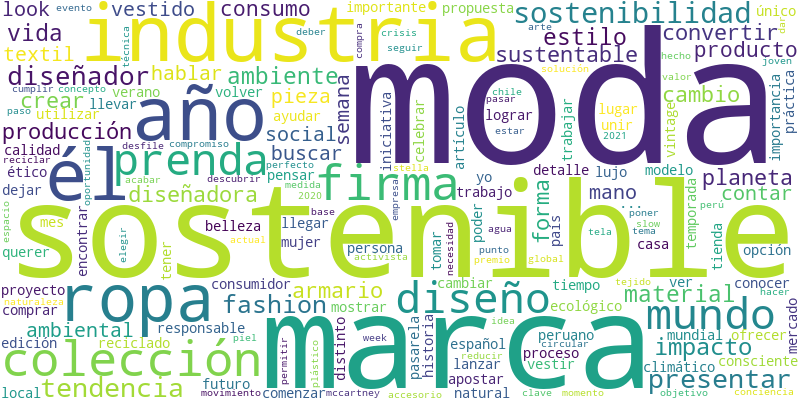

In [32]:
# Plot the Word Cloud
wc = WordCloud(width=800, height=400, background_color="white", min_font_size=10).generate_from_frequencies(word_freq)
wc.to_image()

In [33]:
# The most frequent words in leads for chatbots
chatbot_leads = df.loc[df["source_type"] == "chatbot"]["clean_lead"]
tokens = [
    word.lower()
    for lead in chatbot_leads
    for word in nltk.word_tokenize(lead)
    if word.lower() not in nltk_stopwords.words("spanish")
]
word_freq_chatbot = Counter(tokens)

print("Top 10 most frequent words in chatbot-generated leads:")
for word, frequency in word_freq_chatbot.most_common(10):
    print(f"- {word} (occurrences: {frequency})")

Top 10 most frequent words in chatbot-generated leads:
- moda (occurrences: 150)
- sostenible (occurrences: 86)
- industria (occurrences: 65)
- impacto (occurrences: 37)
- marca (occurrences: 34)
- ambiental (occurrences: 28)
- producción (occurrences: 21)
- tendencia (occurrences: 20)
- práctica (occurrences: 19)
- mundo (occurrences: 18)


In [34]:
# The most frequent words in leads of Latin American magazines
latam_leads = df.loc[
    df["source"].isin(
        [
            "Ocean Drive",
            "Paula",
            "Viste La Calle",
            "Ohlalá",
            "Vogue Mexico",
            "Harper's Bazaar",
            "L'Officiel",
            "Revista COSAS",
        ]
    ),
    "clean_lead",
]
tokens = [
    word.lower()
    for lead in latam_leads
    for word in nltk.word_tokenize(lead)
    if word.lower() not in nltk_stopwords.words("spanish")
]
word_freq_latam = Counter(tokens)

print("Top 10 most frequent words in leads published in Latin American magazines:")
for word, frequency in word_freq_latam.most_common(10):
    print(f"- {word} (occurrences: {frequency})")

Top 10 most frequent words in leads published in Latin American magazines:
- moda (occurrences: 209)
- marca (occurrences: 131)
- año (occurrences: 102)
- colección (occurrences: 78)
- ropa (occurrences: 73)
- industria (occurrences: 71)
- diseño (occurrences: 61)
- mundo (occurrences: 60)
- presentar (occurrences: 57)
- diseñador (occurrences: 56)


In [35]:
# The most frequent words in leads of Spanish magazines
spain_leads = df.loc[df["source"].isin(["InStyle", "Telva", "Vogue Spain"]), "clean_lead"]
tokens = [
    word.lower()
    for lead in spain_leads
    for word in nltk.word_tokenize(lead)
    if word.lower() not in nltk_stopwords.words("spanish")
]
word_freq_spain = Counter(tokens)

print("Top 10 most frequent words in leads published in Spanish magazines:")
for word, frequency in word_freq_spain.most_common(10):
    print(f"- {word} (occurrences: {frequency})")

Top 10 most frequent words in leads published in Spanish magazines:
- moda (occurrences: 141)
- sostenible (occurrences: 97)
- firma (occurrences: 70)
- marca (occurrences: 67)
- sostenibilidad (occurrences: 64)
- prenda (occurrences: 51)
- armario (occurrences: 41)
- año (occurrences: 40)
- industria (occurrences: 37)
- colección (occurrences: 35)


### Creation of the Word2vec models 

#### Parameters
When we create word embedding models we have to take into consideration some of the following important parameters.

| Parameter | Description |
| --- | --- |
| vector_size | The size of the vector that represents each token or word. The number could varies from 50 up to 300 | 
| window | Indicates what the maximum distance between the target word and its neighboring word can be. A window between 2 and 5 gives very good results | 
| min_count | Minimium frequency count of words. The number varies from 1 (keep everything) to 10 (larger minimal frequency), depending of the size of the dataset |
| workers | Workers specifies the number of independent threads doing simultaneous training. Default value = 1 |
| sg | It specificies which approach to use when creating the word embeddings. 0 = continuous bag-of-words; 1 = skip-gram models.
| epochs | Training iterations. The higher the number, the better the word emebddings. Good starting point 10 |

In [36]:
# Define a function that, given a series, processes it and splits it into tokenized sentences
def sentences(series):
    # Clean up the series of documents
    txts = process(series)

    # Tokenize each row, excluding missing ones and the ones that are too short
    sentences = [row.split() for row in txts if row != None and len(row) > 2]
    return sentences

In [37]:
# Extract sentences from leads
human_leads_tokens = sentences(df.loc[df["source_type"] == "human"]["clean_lead"])
chatbot_leads_tokens = sentences(df.loc[df["source_type"] == "chatbot"]["clean_lead"])

In [38]:
# Initialize the first model
leads_human_model = Word2Vec(
    min_count=1,  # Consider words that appear at least N times
    window=4,  # Set the size of the window +/- N words for something to count as a collocation
    workers=1,  # Set the number of CPUs to use
)
leads_human_model.build_vocab(human_leads_tokens, progress_per=50)

# Train the model with the data
leads_human_model.train(
    human_leads_tokens, total_examples=leads_human_model.corpus_count, epochs=30
)

# Check the number of word found in the vocabulary of the first model
print(f"Number of words found in the human leads vocabulary: {len(leads_human_model.wv.index_to_key)}")

Number of words found in the human leads vocabulary: 5614


In [39]:
# Initialize the second model
leads_chatbot_model = Word2Vec(
    min_count=1,  # Consider words that appear at least N times
    window=4,  # Set the size of the window +/- N words for something to count as a collocation
    workers=1,  # Set the number of CPUs to use
)
leads_chatbot_model.build_vocab(chatbot_leads_tokens, progress_per=50)

# Train the model with the data
leads_chatbot_model.train(
    chatbot_leads_tokens, total_examples=leads_chatbot_model.corpus_count, epochs=30
)

# Check the number of word found in the vocabulary of the second model
print(f"Number of words found in the human leads vocabulary: {len(leads_chatbot_model.wv.index_to_key)}")

Number of words found in the human leads vocabulary: 591


In [40]:
# Save the first model
leads_human_model_filename = "lead_human.model"
leads_human_model.wv.save(leads_human_model_filename)

In [41]:
# Save the second model
leads_chatbot_model_filename = "lead_chatbot.model"
leads_chatbot_model.wv.save(leads_chatbot_model_filename)

In [42]:
# Load the second model
leads_human_model = KeyedVectors.load(leads_human_model_filename)
leads_chatbot_model = KeyedVectors.load(leads_chatbot_model_filename)

With both models trained, we can start with the analysis and compare both corpora. The first step is analyze the distances between pairs of words are being calculated using the `.distance()` method of the language model. The inputs to the method are two words, and the output is a floating-point number representing the distance between the two words.

In [43]:
print("Words closest to 'sostenibilidad' (sustainability) in human-written leads:")
for word, distance in leads_human_model.most_similar("sostenibilidad"):
    print(f"- {word} (distance: {distance})")

Words closest to 'sostenibilidad' (sustainability) in human-written leads:
- tema (distance: 0.9994314908981323)
- recibir (distance: 0.9993922114372253)
- invitar (distance: 0.9993876814842224)
- objetivo (distance: 0.9993876814842224)
- empresa (distance: 0.9993836879730225)
- libro (distance: 0.999378502368927)
- ético (distance: 0.9993765950202942)
- empezar (distance: 0.9993681311607361)
- mantener (distance: 0.9993638396263123)
- global (distance: 0.9993627667427063)


In [44]:
print("Words closest to 'sostenibilidad' (sustainability) in chatbot-written leads:")
for word, distance in leads_chatbot_model.most_similar("sostenibilidad"):
    print(f"- {word} (distance: {distance})")

Words closest to 'sostenibilidad' (sustainability) in chatbot-written leads:
- marca (distance: 0.9994328022003174)
- sostenible (distance: 0.9993724822998047)
- moda (distance: 0.9992557764053345)
- modo (distance: 0.999211847782135)
- mundo (distance: 0.999197781085968)
- ropa (distance: 0.9991977214813232)
- utilizar (distance: 0.999194860458374)
- forma (distance: 0.9991732835769653)
- presentar (distance: 0.9991609454154968)
- producción (distance: 0.9991267323493958)


In [45]:
print(
    "Distance between 'joven' (young) and 'sostenibilidad' (sustainability) in human-written leads: "
    + str(leads_human_model.distance("joven", "sostenibilidad"))
)

Distance between 'joven' (young) and 'sostenibilidad' (sustainability) in human-written leads: 0.0008642077445983887


In [46]:
print(
    "Distance between 'mujer' (woman) and 'sostenibilidad' (sustainability) in human-written leads: "
    + str(leads_human_model.distance("mujer", "sostenibilidad"))
)

Distance between 'mujer' (woman) and 'sostenibilidad' (sustainability) in human-written leads: 0.0008973479270935059


Words 'joven' and 'mujer are not present in the `leads_chatbot_model`, so it was not possible to calculate the distance in that case.

### Analysis of article bodies (texts)

In [47]:
# Clean the article bodies
df["clean_body"] = process(df["body"])
df.sample(10, random_state=42)

,source,source_type,date,author,headline,lead,body,keywords,country,clean_headline,clean_lead,clean_body
174,Revista COSAS,human,2022-05-13 21:09:16+00:00,Arianna Gonzales,"El look de Sassa de Osma, perfecto para adopta...",Sassa de Osma vuelve a sorprender con sus esti...,Sassa de Osma vuelve a sorprender con sus esti...,"looks de sassa de osma,sassa de osma",Peru,look sassa osma perfecto adoptar cambio estación,sassa osma volver sorprender estilismo royal p...,sassa osma volver sorprender estilismo royal p...
752,Viste La Calle,human,2018-10-09 13:00:59+00:00,Kevin Cortés,"Renace, una pasarela dedicada 100% a la moda s...","Fotos: Maglio Cicardini (@ballentinno), Isidor...","Fotos: Maglio Cicardini (@ballentinno), Isidor...",moda,Chile,renace pasarela dedicado 100% moda sustentable,fotos maglio cicardini @ballentinno isidora pa...,fotos maglio cicardini @ballentinno isidora pa...
467,Ocean Drive,human,2020-07-17 01:27:59+00:00,Mary Villarroel Sneshko.,“Heart for hope”: Carolina Herrera se une con ...,La reconocida casa de moda ha buscado la maner...,La reconocida casa de moda ha buscado la maner...,"covid-19,moda",Venezuela,heart for hope carolina herrera unir cruz roja...,reconocido casa moda buscar ayudar sobrellevar...,reconocido casa moda buscar ayudar sobrellevar...
240,Harper's Bazaar,human,2022-05-13 00:00:00+00:00,Lorenza García,5 marcas ecológicas de ropa interior que debes...,Si estás haciendo todo lo posible por comprar ...,"Hay muchas marcas que ofrecen estilo, comodida...","moda sostenible,lenceria,marcas de lenceria,ma...",Mexico,marca ecológico ropa interior deber radar,estar comprar sostenible checo marca ecológico...,marca ofrecer estilo comodidad sostenibilidad ...
667,Telva,human,2022-01-18 10:45:18+00:00,Elisa Álvarez Espejo,Las 5 veces que la Reina Letizia ha asaltado e...,Hace 4 años que la reina Letizia hizo incursió...,No sabemos muy bien cómo se abrió la veda en e...,"reina letizia,looks,moda,moda sostenible",Spain,reina letizia asaltar armario doña sofía,año reina letizia incursión guardarropa suegra...,abrir veda armario doña sofía reina letizia lu...
218,Revista COSAS,human,2018-05-08 21:41:09+00:00,Isabel Miró Quesada,"Met Gala 2018: los mejores y los peores looks,...",Conversamos con el diseñador peruano Noe Berna...,Moda y religión se fusionaron en la esperada M...,met gala,Peru,met gala 2018 mejor peor look noe bernacelli,conversar diseñador peruano noe bernacelli pun...,moda religión fusionar esperado met gala ovaci...
867,Vogue Spain,human,2022-11-30 08:34:45.311000+00:00,Emily Chan,¿Cuántas prendas deberíamos tener exactamente?,Un informe del Instituto Hot Or Cool de Berlín...,"""Comprar menos y comprar mejor"" se ha converti...","sostenibilidad,vogue 365",Spain,prenda debeer exactamente,informe instituto hot or cool berlín estimar d...,comprar comprar convertir estribillo común ámb...
420,Ocean Drive,human,2023-01-10 15:45:00+00:00,Mary Villarroel Sneshko.,¿Quién es Amanda Dudamel? 5 datos de nuestra M...,"Elocuente, extrovertida y con una soltura impr...","Elocuente, extrovertida y con una soltura impr...",NaN,Venezuela,amanda dudamel dato miss venezuela 2021,elocuente extrovertido soltura impresionante c...,elocuente extrovertido soltura impresionante c...
351,InStyle,human,2020-06-05 15:24:42+00:00,María Elvira,Marcas de belleza responsables con el medio am...,"Por el Día de la Tierra, repasamos siete marca...",Belleza cosmética El mundo se ha parado en los...,"cosmética,looks de moda,trucos de belleza,prod...",Spain,marca belleza responsable ambiente deber,tierra repasar marca belleza deber respeto pla...,belleza cosmético mundo parar mes situación ja...
328,InStyle,human,2020-09-13 14:00:00+00:00,María Elvira,Cómo cuidar tu melena con los mejores ingredie...,Belleza productos de belleza Si el pelo de tod...,Porque el valor de tu melena es incalculable. ...,productos de belleza,Spain,cuidar melena mejor ingrediente pasar pelo pelazo,belleza producto belleza pelo cotizar bolsa se...,val

In [48]:
# Extract the sentences from the article bodies
human_body_tokens = sentences(df.loc[df["source_type"] == "human"]["clean_body"])
chatbot_body_tokens = sentences(df.loc[df["source_type"] == "chatbot"]["clean_body"])

In [49]:
# Initialize the first model
body_human_model = Word2Vec(
    vector_size=50,  # Set the size of the vector that represents each token or word
    min_count=1,  # Consider words that appear at least N times
    window=4,  # Set the size of the window +/- N words for something to count as a collocation
    workers=1,  # Set the number of CPUs to use
)
body_human_model.build_vocab(human_body_tokens, progress_per=50)

# Train the model with the data
body_human_model.train(
    human_body_tokens, total_examples=body_human_model.corpus_count, epochs=30
)
# Check the number of word found in the vocabulary of the first model
print(f"Number of words found in the human bodies vocabulary: {len(body_human_model.wv.index_to_key)}")

Number of words found in the human bodies vocabulary: 31494


In [50]:
# Initialize the second model
body_chatbot_model = Word2Vec(
    vector_size=50,  # Set the size of the vector that represents each token or word
    min_count=1,  # Consider words that appear at least N times
    window=4,  # Set the size of the window +/- N words for something to count as a collocation
    workers=1,  # Set the number of CPUs to use
)
body_chatbot_model.build_vocab(chatbot_body_tokens, progress_per=50)

# Train the model with the data
body_chatbot_model.train(
    chatbot_body_tokens, total_examples=body_chatbot_model.corpus_count, epochs=30
)

# Check the number of word found in the vocabulary of the second model
print(f"Number of words found in the chatbot bodies vocabulary: {len(body_chatbot_model.wv.index_to_key)}")

Number of words found in the chatbot bodies vocabulary: 2424


In [51]:
# Save the first model
body_human_model_filename = "body_human.model"
body_human_model.wv.save(body_human_model_filename)

In [52]:
# Save the second model
body_chatbot_model_filename = "body_chatbot.model"
body_chatbot_model.wv.save(body_chatbot_model_filename)

In [53]:
# Load the second model
body_human_model = KeyedVectors.load(body_human_model_filename)
body_chatbot_model = KeyedVectors.load(body_chatbot_model_filename)

In [54]:
# Define a function that calculates the distance between two words for both the human and chatbot model
def body_human_chatbot_distance(first_word, first_word_en, second_word, second_word_en):
    distance_human = body_human_model.distance(first_word, second_word)
    distance_chatbot = body_chatbot_model.distance(first_word, second_word)
    print(
        f"Distance between '{first_word}' ({first_word_en}) and '{second_word}' ({second_word_en}) in article bodies:"
    )
    print(f"- Human-written: {distance_human}")
    print(f"- Chatbot-written: {distance_chatbot}")


# Define a function that calculates the 10 most similar words to the given one for both the human and chatbot model
def body_human_chatbot_most_similar(word, word_en):
    most_similar_human = body_human_model.most_similar(word)
    most_similar_chatbot = body_chatbot_model.most_similar(word)

    print(
        f"Top 10 most similar words to '{word}' ({word_en}) in human-written article bodies:"
    )
    for term, distance in most_similar_human:
        print(f"- {term} (distance: {distance})")

    print(
        f"\nTop 10 most similar words to '{word}' ({word_en}) in chatbot-written article bodies:"
    )
    for term, distance in most_similar_chatbot:
        print(f"- {term} (distance: {distance})")


# Define a function that calculates the 10 most similar words to the association of two given terms, excluding a third (negative) one
def body_human_chatbot_most_similar_compare(
    positive_first,
    positive_first_en,
    positive_second,
    positive_second_en,
    negative,
    negative_en,
):
    top_num = 10  # How many similar words to extract
    most_similar_human = body_human_model.most_similar(
        positive=[positive_first, positive_second], negative=[negative], topn=top_num
    )
    most_similar_chatbot = body_chatbot_model.most_similar(
        positive=[positive_first, positive_second], negative=[negative], topn=top_num
    )

    print(
        f"Word similarity in human-written article bodies: '{positive_first}' ({positive_first_en}) + '{positive_second}' ({positive_second_en}) - '{negative}' ({negative_en}):"
    )
    for term, distance in most_similar_human:
        print(f"- {term} (distance: {distance})")

    print(
        f"\nWord similarity in chatbot-written article bodies '{positive_first}' ({positive_first_en}) + '{positive_second}' ({positive_second_en}) - '{negative}' ({negative_en}) in chatbot-written article bodies:"
    )
    for term, distance in most_similar_chatbot:
        print(f"- {term} (distance: {distance})")

In [55]:
body_human_chatbot_distance("local", "local", "sostenibilidad", "sustainability")

Distance between 'local' (local) and 'sostenibilidad' (sustainability) in article bodies:
- Human-written: 0.8065246939659119
- Chatbot-written: 0.36555373668670654


In [56]:
body_human_chatbot_distance("local", "local", "marca", "brand")

Distance between 'local' (local) and 'marca' (brand) in article bodies:
- Human-written: 0.8197443187236786
- Chatbot-written: 0.20579326152801514


In [57]:
body_human_chatbot_most_similar("mujer", "woman")

Top 10 most similar words to 'mujer' (woman) in human-written article bodies:
- hombre (distance: 0.6846300959587097)
- reviveír (distance: 0.6496820449829102)
- insensibilidad (distance: 0.6185675263404846)
- baveír (distance: 0.6161431074142456)
- niña (distance: 0.5840340256690979)
- malestar (distance: 0.5827069878578186)
- desamparo (distance: 0.5736085772514343)
- género (distance: 0.5694658756256104)
- criar (distance: 0.5649791359901428)
- adolescente (distance: 0.5598500967025757)

Top 10 most similar words to 'mujer' (woman) in chatbot-written article bodies:
- diseñadora (distance: 0.9968432188034058)
- virgil (distance: 0.9962515234947205)
- américo (distance: 0.9957792162895203)
- chanel (distance: 0.9957160353660583)
- género (distance: 0.995695948600769)
- mexicano (distance: 0.9956561923027039)
- listo (distance: 0.995648980140686)
- vogue (distance: 0.9955419301986694)
- marginado (distance: 0.9955342411994934)
- edad (distance: 0.9955337047576904)


In [58]:
body_human_chatbot_distance("moda", "fashion", "sostenible", "sustainable")

Distance between 'moda' (fashion) and 'sostenible' (sustainable) in article bodies:
- Human-written: 0.8898274749517441
- Chatbot-written: 0.18716663122177124


In [59]:
body_human_chatbot_distance("moda", "fashion", "clima", "climate")

Distance between 'moda' (fashion) and 'clima' (climate) in article bodies:
- Human-written: 0.6740624606609344
- Chatbot-written: 0.2221718430519104


In [60]:
body_human_chatbot_distance("moda", "fashion", "mundo", "world")

Distance between 'moda' (fashion) and 'mundo' (world) in article bodies:
- Human-written: 0.800218403339386
- Chatbot-written: 0.059557199478149414


In [61]:
body_human_chatbot_distance("moda", "fashion", "colonialismo", "colonialism")

Distance between 'moda' (fashion) and 'colonialismo' (colonialism) in article bodies:
- Human-written: 0.992447854951024
- Chatbot-written: 0.22330981492996216


In [62]:
body_human_chatbot_distance("moda", "fashion", "industria", "industry")

Distance between 'moda' (fashion) and 'industria' (industry) in article bodies:
- Human-written: 0.7190319895744324
- Chatbot-written: 0.08575439453125


In [63]:
body_human_chatbot_most_similar_compare(
    "mujer", "woman", "moda", "fashion", "hombre", "man"
)

Word similarity in human-written article bodies: 'mujer' (woman) + 'moda' (fashion) - 'hombre' (man):
- modo (distance: 0.5443403124809265)
- kaiser (distance: 0.4664469063282013)
- trabajarir (distance: 0.46084165573120117)
- superado (distance: 0.4589770436286926)
- maquillador (distance: 0.4526357650756836)
- remar (distance: 0.44641393423080444)
- comunicar (distance: 0.4406602680683136)
- textilería (distance: 0.43647196888923645)
- olección (distance: 0.43394094705581665)
- economía (distance: 0.43353307247161865)

Word similarity in chatbot-written article bodies 'mujer' (woman) + 'moda' (fashion) - 'hombre' (man) in chatbot-written article bodies:
- modo (distance: 0.9695124626159668)
- convertir (distance: 0.9662811756134033)
- conclusión (distance: 0.9660041928291321)
- cambio (distance: 0.9657852053642273)
- futuro (distance: 0.9635902643203735)
- industria (distance: 0.9540789127349854)
- terreno (distance: 0.9537091851234436)
- tendencia (distance: 0.9534328579902649)
- cr

In [64]:
body_human_chatbot_most_similar_compare(
    "hombre", "man", "moda", "fashion", "mujer", "woman"
)

Word similarity in human-written article bodies: 'hombre' (man) + 'moda' (fashion) - 'mujer' (woman):
- modo (distance: 0.6419758200645447)
- traicionar (distance: 0.5333430171012878)
- pecado (distance: 0.5205049514770508)
- criticartir (distance: 0.5161091685295105)
- secretaría (distance: 0.506213903427124)
- no- (distance: 0.5057329535484314)
- invitado (distance: 0.503787100315094)
- inspiradoro (distance: 0.5034504532814026)
- planteo (distance: 0.5021536350250244)
- bottle (distance: 0.49154993891716003)

Word similarity in chatbot-written article bodies 'hombre' (man) + 'moda' (fashion) - 'mujer' (woman) in chatbot-written article bodies:
- presentar (distance: 0.9711872935295105)
- esperar (distance: 0.9558221101760864)
- resumen (distance: 0.9459088444709778)
- popularizar (distance: 0.9451967477798462)
- junto (distance: 0.9388555288314819)
- ganar (distance: 0.9387624859809875)
- explicar (distance: 0.9321936964988708)
- sustentable (distance: 0.9321531653404236)
- papel (d

In [65]:
body_human_chatbot_most_similar_compare(
    "mujer", "woman", "marca", "brand", "hombre", "man"
)

Word similarity in human-written article bodies: 'mujer' (woman) + 'marca' (brand) - 'hombre' (man):
- firma (distance: 0.6387438774108887)
- marcar (distance: 0.5707240700721741)
- sello (distance: 0.4826177656650543)
- bohodot (distance: 0.48030343651771545)
- firmar (distance: 0.4785173833370209)
- kowtow (distance: 0.4747653007507324)
- lujo (distance: 0.46787866950035095)
- ético (distance: 0.4658910036087036)
- mifuko (distance: 0.46116140484809875)
- nachaber (distance: 0.45849835872650146)

Word similarity in chatbot-written article bodies 'mujer' (woman) + 'marca' (brand) - 'hombre' (man) in chatbot-written article bodies:
- marcar (distance: 0.9606087803840637)
- práctico (distance: 0.9553403854370117)
- caer (distance: 0.9481027722358704)
- evitar (distance: 0.929162859916687)
- sostenible (distance: 0.9286097884178162)
- verificar (distance: 0.9268375635147095)
- común (distance: 0.9250891208648682)
- empresa (distance: 0.9241806864738464)
- distinguir (distance: 0.92285501

In [66]:
body_human_chatbot_most_similar_compare(
    "mujer", "woman", "sostenibilidad", "sustainability", "hombre", "man"
)

Word similarity in human-written article bodies: 'mujer' (woman) + 'sostenibilidad' (sustainability) - 'hombre' (man):
- sustentabilidad (distance: 0.6181811690330505)
- transparencia (distance: 0.5818570852279663)
- circularidad (distance: 0.5709753036499023)
- sumo (distance: 0.524152934551239)
- @bonoboss (distance: 0.5006284713745117)
- concientización (distance: 0.4972883462905884)
- ecología (distance: 0.49553394317626953)
- sostenible (distance: 0.4881688058376312)
- eco (distance: 0.4696113169193268)
- ecoblanqueo (distance: 0.46216291189193726)

Word similarity in chatbot-written article bodies 'mujer' (woman) + 'sostenibilidad' (sustainability) - 'hombre' (man) in chatbot-written article bodies:
- enfrentar (distance: 0.936558187007904)
- desafío (distance: 0.9312096834182739)
- marco (distance: 0.924890398979187)
- tema (distance: 0.9238261580467224)
- comenzar (distance: 0.9132041335105896)
- preocupación (distance: 0.9130990505218506)
- confundir (distance: 0.9126828312873

In [67]:
body_human_chatbot_most_similar_compare(
    "mujer", "woman", "clima", "climate", "hombre", "man"
)

Word similarity in human-written article bodies: 'mujer' (woman) + 'clima' (climate) - 'hombre' (man):
- desencantado (distance: 0.6294215321540833)
- feminismo (distance: 0.6073720455169678)
- contexto (distance: 0.6002323627471924)
- paidós (distance: 0.5996465086936951)
- interrogant (distance: 0.5917478203773499)
- amplitud (distance: 0.5906208157539368)
- covid-19 (distance: 0.5720852017402649)
- normalidad (distance: 0.5607677698135376)
- migratorio (distance: 0.560438871383667)
- humanidad (distance: 0.560369074344635)

Word similarity in chatbot-written article bodies 'mujer' (woman) + 'clima' (climate) - 'hombre' (man) in chatbot-written article bodies:
- digital (distance: 0.9908615946769714)
- poderoso (distance: 0.9906161427497864)
- representar (distance: 0.9904299974441528)
- famoso (distance: 0.9904019832611084)
- avance (distance: 0.9904013872146606)
- textile (distance: 0.9901056289672852)
- francamagazine (distance: 0.9901034832000732)
- llamado (distance: 0.990042328

In [68]:
body_human_chatbot_most_similar_compare(
    "mujer", "woman", "compra", "buy", "hombre", "man"
)

Word similarity in human-written article bodies: 'mujer' (woman) + 'compra' (buy) - 'hombre' (man):
- acercarte (distance: 0.6177152991294861)
- descuento (distance: 0.6139680743217468)
- pasaremos (distance: 0.5603664517402649)
- fransoublette.com (distance: 0.5602855682373047)
- www.leapingbunny.org (distance: 0.5572226047515869)
- membresía (distance: 0.5562737584114075)
- cuantioso (distance: 0.5422312617301941)
- impulsivo (distance: 0.5367271304130554)
- profundicer (distance: 0.5335382223129272)
- comparativo (distance: 0.5324923396110535)

Word similarity in chatbot-written article bodies 'mujer' (woman) + 'compra' (buy) - 'hombre' (man) in chatbot-written article bodies:
- actitud (distance: 0.9790014624595642)
- volver (distance: 0.9779215455055237)
- noticia (distance: 0.975894033908844)
- frente (distance: 0.9732661843299866)
- socialmente (distance: 0.9731048345565796)
- explicar (distance: 0.972385585308075)
- alentar (distance: 0.9715802073478699)
- aguo (distance: 0.970

#### Woman/Man - Sustainable

In [69]:
body_human_chatbot_distance("mujer", "woman", "sostenible", "sustainable")
body_human_chatbot_distance("hombre", "man", "sostenible", "sustainable")

Distance between 'mujer' (woman) and 'sostenible' (sustainable) in article bodies:
- Human-written: 0.822450116276741
- Chatbot-written: 0.3663790225982666
Distance between 'hombre' (man) and 'sostenible' (sustainable) in article bodies:
- Human-written: 0.8773988336324692
- Chatbot-written: 0.40299129486083984


### NAIVE 2D Projection

The NAIVE 2D projection is a form of visualization of the Word2Vec vector space that represents the relationships between words on a two-dimensional plane. We use it to determine potential biases by plotting the position of test words with regard to two couples of antonyms.

The words that we are going to test:

In [70]:
test_words = [
    "calidad",
    "diseño",
    "reparar",
    "costura",
    "textil",
    "artesanía",
    "económico",
    "reutilizar",
    "reciclado",
    "barato",
    "urbano",
    "sostenible",
    "sustentable",
    "inversión",
    "lujo",
    "exclusivo",
]

In [71]:
# Define the function that plots the NAIVE 2D Projection
def naive_projection(wv_model, x_axis, y_axis, test_words, plot_size=6):
    # Validate input data
    if len(x_axis) != 2:
        print("You must only have two antonyms in your x-axis")
    elif len(y_axis) != 2:
        print("You must only have two antonyms in your y-axis")
    else:  # Proceed with the projection
        # Lists that will store the values for each test word
        x = list()
        y = list()

        # Check that all test words are present in the model
        present_words = []
        for word in test_words:
            if not wv_model.__contains__(word):
                print(f"The model does not contain the word '{word}', skipping it")
            else:
                present_words.append(word)

        # Calculate the x and y coordinates for each test word
        for word in present_words:
            x_val = wv_model.distance(x_axis[0], word) - wv_model.distance(
                x_axis[1], word
            )  # x_axis[0] is the first word of the antonym pair, x_axis[1] is the second word
            y_val = wv_model.distance(y_axis[0], word) - wv_model.distance(
                y_axis[1], word
            )  # Same thing with y: 0/1 here select the second antonym pair
            x.append(x_val)  # Save x/y in our lists above
            y.append(y_val)

        # Plot the x/y values just calculated
        fig, ax = plt.subplots(figsize=(plot_size, plot_size))

        # Show origin axes
        ax.axhline(y=0, color="0.7")
        ax.axvline(x=0, color="0.7")

        for i in range(len(x)):
            ax.scatter(x[i], y[i])
            ax.annotate(present_words[i], (x[i], y[i]))

        xlab = x_axis[0] + " --- " + x_axis[1]
        ylab = y_axis[0] + " --- " + y_axis[1]
        plt.xlabel(xlab)
        plt.ylabel(ylab)

        plt.show()

#### Socio-economic bias

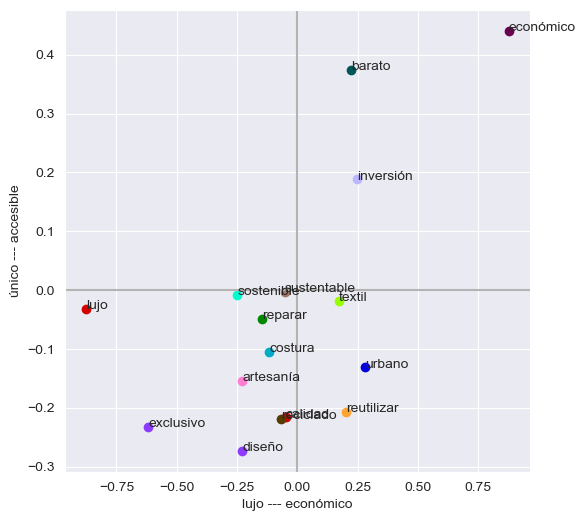

In [72]:
# Socio-economic bias / human
x_axis = ["lujo", "económico"]
y_axis = ["único", "accesible"]
naive_projection(body_human_model, x_axis, y_axis, test_words)

The model does not contain the word 'exclusivo', skipping it


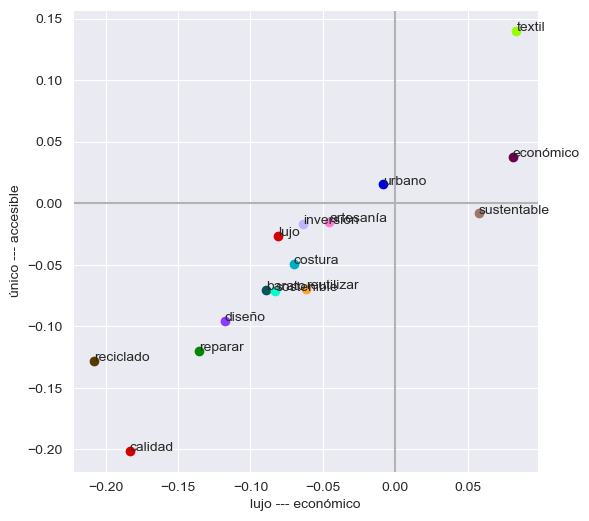

In [73]:
# Socio-economic bias / chatbot
x_axis = ["lujo", "económico"]
y_axis = ["único", "accesible"]
naive_projection(body_chatbot_model, x_axis, y_axis, test_words)

#### Geographic bias

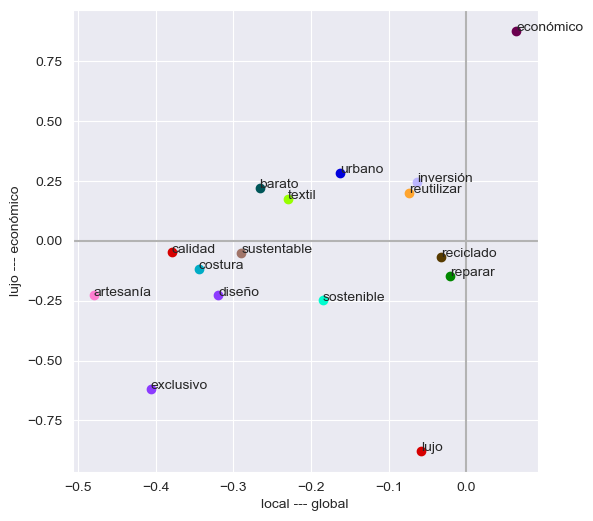

In [74]:
# Geographic bias / human
x_axis = ["local", "global"]
y_axis = ["lujo", "económico"]
naive_projection(body_human_model, x_axis, y_axis, test_words)

The model does not contain the word 'exclusivo', skipping it


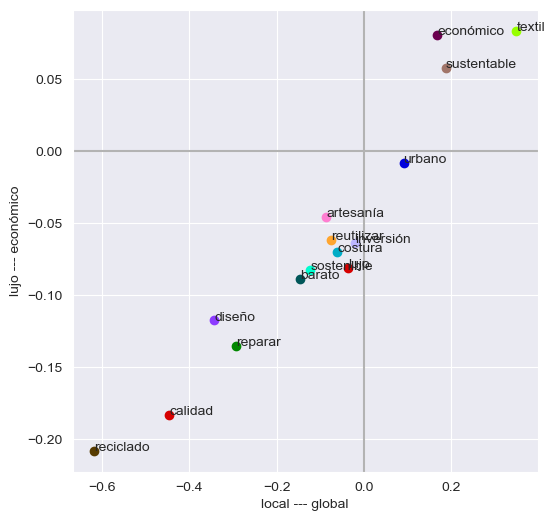

In [75]:
# Geographic bias / chatbots
x_axis = ["local", "global"]
y_axis = ["lujo", "económico"]
naive_projection(body_chatbot_model, x_axis, y_axis, test_words)